In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Er, Esref (1068926)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I started with a dense layer of 32 neurons and iteratively added a dense layer with twice the neurons until the network stopped underfitting. I chose ELU since it is not too sensitive to vanishing gradients and removes the dying ReLU problem. I tried all default Keras optimizers, and Nadam worked best. I chose softmax as activation function in the output layer, since it works well with categorical_crossentropy. The network works quite well, but starts overfitting after 15 epochs. (length: 485)



Max val score: 81.74%


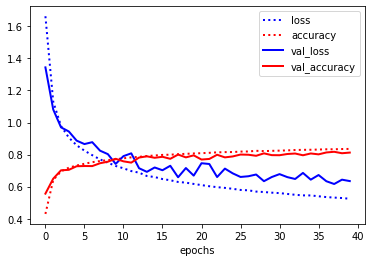

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_51 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_211 (Dense)            (None, 128)               393344    
_________________________________________________________________
dense_212 (Dense)            (None, 64)                8256      


_________________________________________________________________
dense_213 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_214 (Dense)            (None, 10)                330       
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(32, activation='elu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='Nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



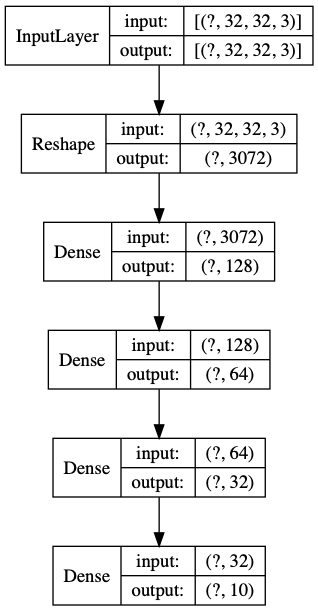

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

Data is lost by converting the images to greyscale. This shrinks the input shape from (32,32,3) to (32,32,1). Data may be lost, but color is not important when it comes to catogoraizing images of numbers. The first few epochs have the biggest difference in accuracy. The model learns faster, since there is less 'noise' in the data. As a result, the model requires less epochs to get the same accuracy from the previous model, making it a better model. However, it starts to overfit earlier. (length: 492)



Max val score: 81.24%


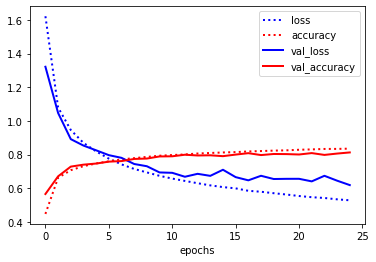

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_37 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_153 (Dense)            (None, 128)               131200    
_________________________________________________________________
dense_154 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_155 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_156 (Dense)            (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(32, activation='elu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='Nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

The base amount of layers/neurons has not been adjusted due to the build-up strategy of 1.1. I did a gridsearch to determine the regularizer and regularizer factor. I tried batch normalization, but the network got worse. Gradually increasing the amount of dropout rate worked best. This forces layers deep in the model to regularize more. It is recommended to use default values for Nadam. The generalization performance of the network has improved, resulting in higher overall accuracy on X_val. (length: 497)



Max val score: 83.82%


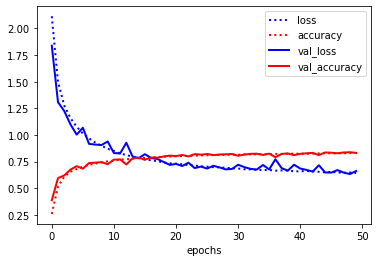

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001 / 10),activation='elu'))
    model.add(layers.Dropout(0.3 / 10))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001 / 10), activation='elu'))
    model.add(layers.Dropout(0.4 / 10))
    model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001 / 10), activation='elu'))
    model.add(layers.Dropout(0.5 / 10))
    model.add(layers.Dense(10,activation='softmax'))
    model.compile(optimizer='Nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

The number of filters learning is increasing as the output spatial volume is decreasing. I have done this, since it is a common practice in designing CNN architectures. After every two Conv2d there is a Max Pooling layer, since more convolution before reducing the size can lead to more interesting representations of the data, and improve the accuracy. A kernel size of 3x3 is chosen, since the input is small. Gradually increasing the amount of dropout rate worked best. This forces layers deep in the model to regularize more. The network converged more quickly and trained faster with the use of batch normalization. A final fully conntected layer is added, since this is common practive and increased the accuracy. The model works well, but starts slightly overfitting after 20 epochs. (length: 791)



Max val score: 94.70%


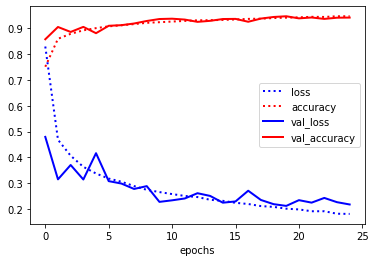

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_121 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_122 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_110 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 16, 16, 64)      

def build_model_2_1():
    model = models.Sequential()
    
    #Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4)) 

    #Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4))
    
    #Final Dense Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    
    #Output Layer
    model.add(

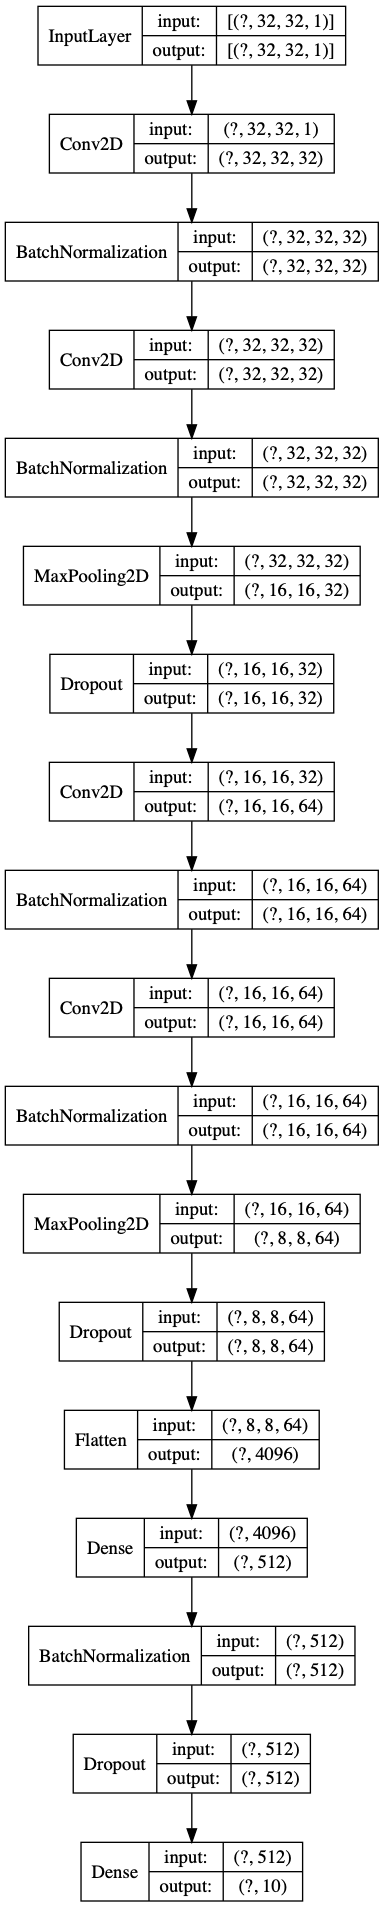

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

The validation accuracy is much higher than the training accuracy in the first 30 epochs. This is probably due to the fact that the train data contains more 'difficult' data to learn. We get the best results with very subtle data augmentation (small shifts, rotations, zooms and rescales), because the images are low resolution and too many editing results in too much information loss. Flipped images do not appear in the data set, so they cause noise. (length: 454)



Max val score: 95.32%


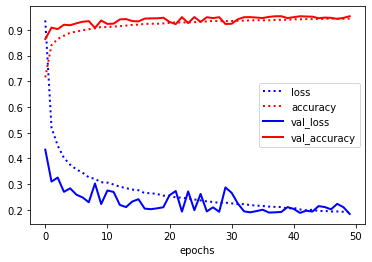


train_datagen = ImageDataGenerator(
rotation_range=10,
width_shift_range=1.1,
height_shift_range=1.1,
zoom_range=[0.9,1.1],
rescale=1.1
)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

The accuracy on the test set was about 95%. You can see from the confusion matrix that the numbers that are confused with each other often look alike. Take 1 and 7 for example. It can also be seen that numbers with simple shapes such as 1 are often confused with others. I've researched images predicted 6 but are actual a 3, since they don't look alike. These confusions are usually due to poor photo quality, background noises and weird typography. (length: 451)

Test score: 0.95%


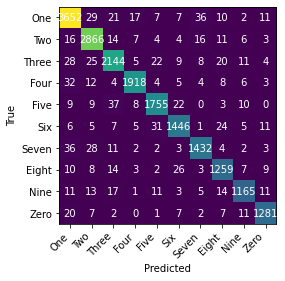

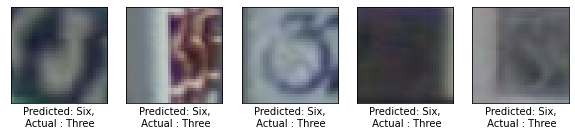

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

The first 2 convolution layers are various edge detectors. There are alot of empty filter activation in the first convolution layer, this happends when the input image does not have the information that the filter was interested in. Within the 3rd convolution layer it can be seen that the activations are becoming more and more abstract. The filter is activating on for example: the top/bottom part of the 8 and also the two holes. The activations on the last layer become even more abstract. (length: 494)



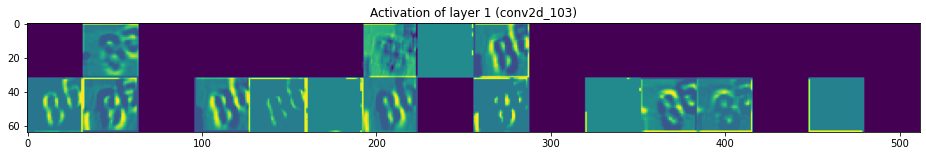

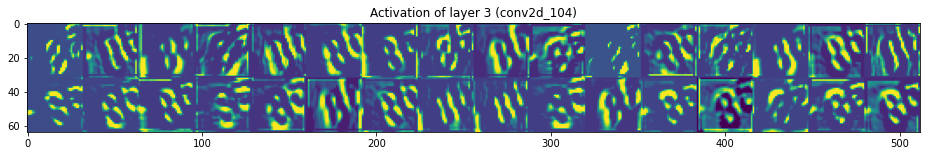

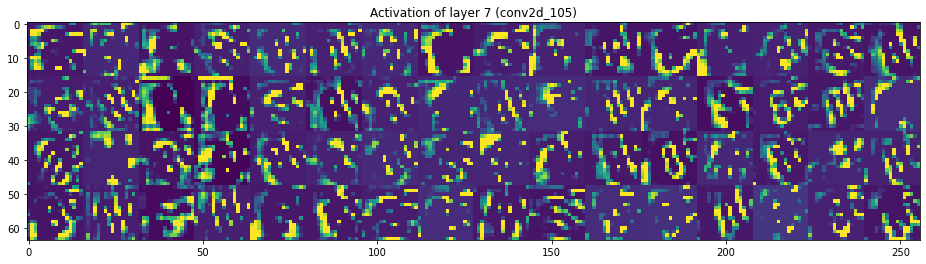

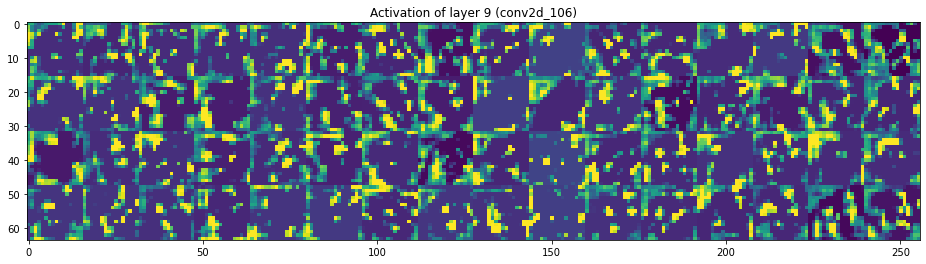

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

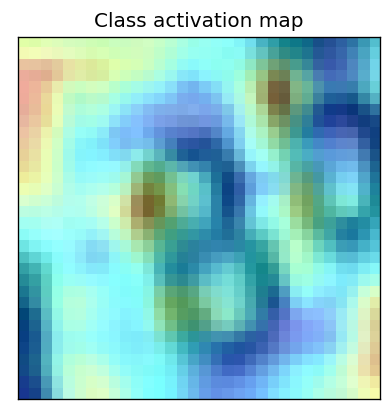

def plot_3_3():
    model = load_model_from_file(base_dir, 'model_2_2')
    # `x` is a float32 Numpy array of shape (224, 224, 3)
    x = rgb2gray(X_test)[0]
    x = np.expand_dims(x, axis=0)

    african_elephant_output = model.output[:,7]

    # The is the output feature map of the `block5_conv3` layer,
    # the last convolutional layer in VGG16
    last_conv_layer = model.get_layer('conv2d_106')

    # This is the gradient of the "african elephant" class with regard to
    # the output feature map of `block5_conv3`
    grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image

    iterate = K.function([mode

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

We get very poor performance when we use the fast feature extraction method. Fine-tuning works better, with the last block (block5_conv1) being unfreezed, but it starts heavily overfitting after 6 epochs. The accuracy on the validation set does not exceed 82%. VVG16 model is made to classify 1000 different objects in the imagenet dataset, not including numbers. Our network is performing better, we can conclude that VVG16 is not the network to use for this case. (length: 466)



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

Max val score: 81.91%


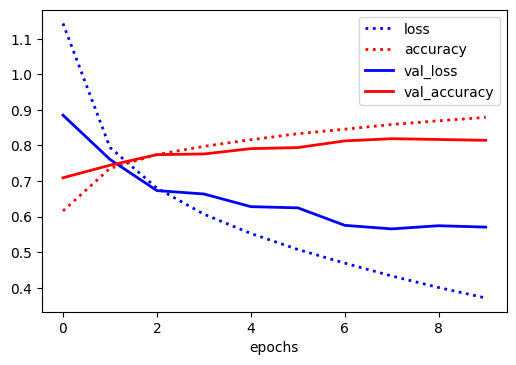

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________
None


def build_model_4_1():
    conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(32, 32, 3),
                 pooling='max')
    conv_base.summary()
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))  
    model.add(layers.Dense(10, activation='softmax'))
    conv_base.trainable = True

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    rms = optimizers.RMSprop(learning_rate=0.00002, rho=0.9, momentum=0.0, epsilon=1e-07, centered=True)

    model.compile(optimizer=rms,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



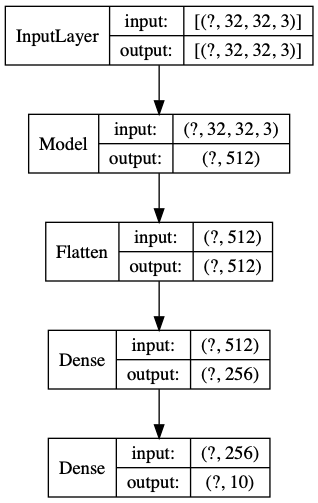

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I loaded the network from 4_2 and popped the dense layers off. Then I made several pipelines with different classifiers. Including RandomForest, LogisticRegression and SupportVector. I did a grid search for each classifier for the relevant parameters. Random forest came out best in the tests, although they were all very similar in accuracy. The accuracy is (almost) the same as 2_2, but no better than 4_2. (length: 409)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=0.05, n_estimators=250))])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model = load_model_from_file(base_dir, 'model_4_1')
    model._layers.pop()
    model._layers.pop()
    model._layers.pop()
    store_embedding(model.predict(X_train), 'Train')
    store_embedding(model.predict(X_test), 'Test')
    store_embedding(model.predict(X_val), 'Validation')

def evaluation_4_2(X_train, y_

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 31.80 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
